# NOT YET ADAPTED FOR GENERAL USE

# Image Segmentation Models: Best Model Training and Predictions

Notebook adapted from [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet)

In [ ]:
# Dependencies
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

In [ ]:
!pip install -U segmentation-models

In [ ]:
# Replace saving.py file with fix. NEED TO RESTART RUNTIME AFTERWARDS
#!cp /content/drive/MyDrive/Trustbit/saving.py /usr/local/lib/python3.7/dist-packages/keras/engine/

In [ ]:
import os
import cv2
import numpy as np
import random
import gc
import pickle

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
/content/drive/MyDrive/Trustbit/U-Net-YT


In [ ]:
# Set working directory if necessary
#%cd /content/drive/MyDrive/Trustbit/U-Net-YT

# SPECIFY IMAGE SIZE
patch_size = 480

## Load custom data into memory for testing

In [ ]:
# Load custom data
image_dataset = []  
image_name_ls = []

path = "custom/path"

images = os.listdir(path)  #List of all image names in this subdirectory
images.sort()


for i in images:
    image = cv2.imread(path+"/"+i, 1)  #Read each image as BGR
    
    image = Image.fromarray(image)                                      ##### PSPNet
    image = image.resize((480, 480))

    image = np.array(image)
    
    img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
            
    image_dataset.append(img)

X_test = image_dataset

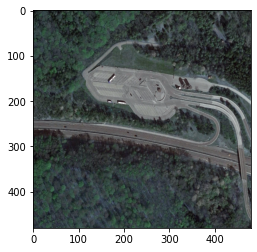

In [ ]:
# Check images
rnr = random.randint(0, len(X_test))
plt.imshow(X_test[rnr])
plt.show()

## Load images in memory for training

In [ ]:
# SPECIFY DATA PATH
# Must contain raw images and masks!
path = "data/training_data_Mask"

In [19]:
# Read images from respective directory

# SPECIFY MAX NUMBER OF IMAGES THAT SHOULD BE LOADED (must be odd)
max_images = 399

if max_images % 2 != 1:
    raise ValueError("Max number of images must be odd!")


image_dataset = []  
mask_dataset = []
image_name_ls = []
mask_name_ls = []
counter = 0

images = os.listdir(path)  # List of all image names in this subdirectory
images.sort()

for i, image_name in enumerate(images):
    if counter > max_images:
        if len(image_dataset) == len(mask_dataset):
            break

    if image_name.endswith(".jpeg") and image_name.startswith("T"):   # Only read truck and jpg images
        image = cv2.imread(path+"/"+image_name, 1)  # Read each image as BGR
        
        #image = image.crop((0 ,0, 480, 480))  # Crop from top left corner
        #image = image.resize((480, 480))      # Resize image, try not to use
        image = np.array(image)
        
        img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                
        image_dataset.append(img)
        image_name_ls.append(image_name)

    elif image_name.endswith("MASK.png") and image_name.startswith("T"): # Load mask
        mask = cv2.imread(path+"/"+image_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        #mask = mask.crop((0 ,0, 480, 480))  # Crop from top left corner
        #mask = mask.resize((480, 480))      # Resize image, try not to use
        mask = np.array(mask)   

        mask_dataset.append(mask)
        mask_name_ls.append(image_name)

        counter += 1


# Transform lists to numpy arrays and check if lengths are identical
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

if len(image_dataset) != len(mask_dataset):
    print("ERROR: Lengths differ!")
else:
    print("Images:", len(image_dataset))

Images: 0


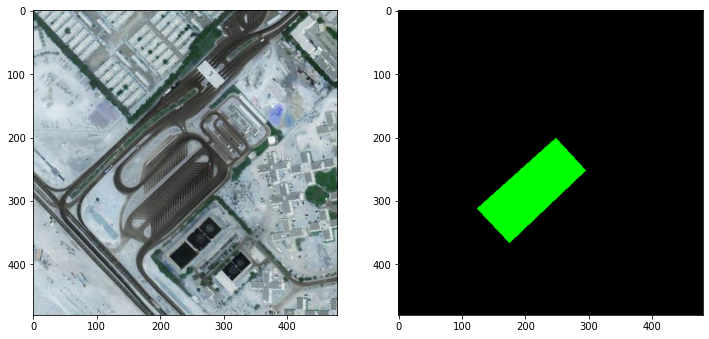

In [ ]:
# Sanity check: Images loaded correct? Mask fits to image?
image_number = random.randint(0, len(image_dataset))
#image_number = 4

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

## Image processing

In [ ]:
# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# if matches then replace all values in that pixel with a specific integer
background =    np.array([0, 0, 0])
truck_parking = np.array((0, 255, 0))
car_parking =   np.array((0, 0, 255))

def rgb_to_2D_label(label):
    
    #Supply our labale masks as input in RGB format. 
    #Replace pixels with specific RGB values ...

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label==background, axis=-1)] = 0
    label_seg[np.all(label==truck_parking, axis=-1)] = 1 # Trucks
    label_seg[np.all(label==car_parking, axis=-1)] = 2   # Cars
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

# Check if there are only as many entries as classes + 1 (background)
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


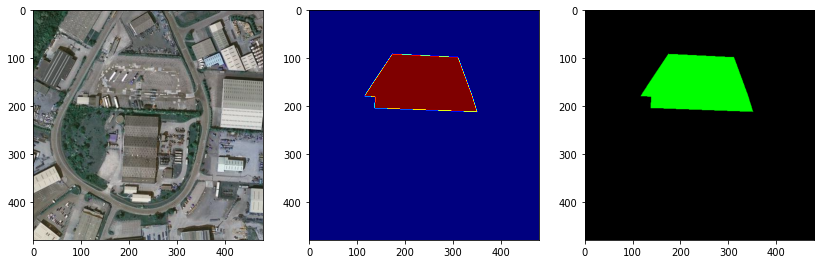

In [ ]:
# Another Sanity check: Are labels and masks correctly assigned to image and class?
image_number = random.randint(0, len(image_dataset)-1)
#image_number = 0

plt.figure(figsize=(14, 8))
plt.subplot(131)
plt.imshow(image_dataset[image_number])
plt.subplot(132)
plt.imshow(labels[image_number][:,:,0], cmap='jet')
plt.subplot(133)
plt.imshow(mask_dataset[image_number])
plt.show()

## Train-Test-Split

In [ ]:
# CAUTION: This process will delete the old lists to free up memory
n_classes = len(np.unique(labels))

del mask_dataset 
del image_name_ls 
del mask_name_ls 
gc.collect()

# Change labels to categories
labels_cat = to_categorical(labels, num_classes=n_classes)
del labels 
gc.collect()

# Perform train-test-split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
#_, X_test, _, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

del image_dataset
gc.collect()

0

## Augmentation of train data set

In [ ]:
# Augmentation
X_train_temp = []
y_train_temp =  []

np.random.seed(101)

for i in range(len(X_train)):
    if len(X_train_temp) != len(y_train_temp):
        print("Lengths differ! Job aborted.")
        break

    # INCLUDE COUNTER

    img = X_train[i]
    mask = y_train[i]

    X_train_temp.append(img)
    y_train_temp.append(mask)

    if np.random.randint(0,101) > 95:  # SPECIFY PROBABILITY OF RANDOM ROTATION
        # 90 degree rotation
        angle = np.random.randint(1,4)

        img_aug = np.rot90(img, angle)

        mask_aug = np.rot90(mask, angle)

        X_train_temp.append(img_aug)
        y_train_temp.append(mask_aug)


    if np.random.randint(0,101) > 50: # SPECIFIY PROBABILITY OF VERTICAL FLIP
        # vertical flip
        img_aug2 = np.flip(img, 0)
        mask_aug2 = np.flip(mask, 0)

        X_train_temp.append(img_aug2)
        y_train_temp.append(mask_aug2)

    else:
        # horizonal flip
        img_aug3 = np.flip(img, 1)
        mask_aug3 = np.flip(mask, 1)

        X_train_temp.append(img_aug3)
        y_train_temp.append(mask_aug3)


# Transform lists to numpy arrays and check if lengths are identical
X_train = np.array(X_train_temp)
y_train =  np.array(y_train_temp)

del X_train_temp
del y_train_temp
gc.collect()

if len(X_train) != len(y_train):
    print("ERROR: Lengths differ!")
else:
    print("Images:", len(X_train))

Images: 886


In [ ]:
# Sanity check
image_number = random.randint(0, len(X_train)-1)
#image_number = 0
print(image_number)

X_img = X_train[image_number]

y_img = y_train[image_number]
y_img_input = np.expand_dims(y_img, 0)
y_img_input = np.argmax(y_img_input, axis=3)[0,:,:]

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(X_img)
plt.subplot(122)
plt.imshow(y_img_input)
plt.show()

## Training

In [ ]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', classes=np.unique(np.ravel(labels, order='C')), y=np.ravel(labels, order='C'))
#print("weights:", weights)

# OR MANUALLY SPECIFY WEIGTHS ACCORDING TO NUMBER OF CLASSES
#weights = [1/3, 1/3, 1/3]
weights = [0.5, 0.5]

dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Training with Segmentation-Models API

In [ ]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  
metrics=['accuracy', jacard_coef, sm.metrics.IOUScore(), sm.metrics.FScore(), sm.metrics.Precision(), sm.metrics.Recall()] # Define metrics shown

#SPECIFY BACKBONE (WITH PRETRAINED WEIGHTS ON IMAGNET)
BACKBONE = 'resnet50'  
#BACKBONE = "resnet101" # "senet154", "resnet34", 'efficientnetb4', "inceptionv3"
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

activation = 'sigmoid' if n_classes == 1 else 'softmax' # softmax or sigmoid for 1 class

# DEFINE MODEL
# https://github.com/qubvel/segmentation_models
# https://segmentation-models.readthedocs.io/en/latest/api.html#pspnet # Parameters!
model_resnet_backbone = sm.PSPNet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation, input_shape=(480, 480, 3),
                                  downsample_factor = 16) 


# compile keras model with defined optimizer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model_resnet_backbone.summary())

171171840/171164896 [==============================] - 15s 0us/step


In [ ]:
# Fit Model
from datetime import date, datetime
date_model = date.today().strftime("%b-%d-%Y")
time_model = datetime.now().strftime("%H:%M")

import time 
start_time = time.localtime()
start_t = time.time()
print("Started at:", time.asctime(start_time))

# Cf. https://keras.rstudio.com/reference/fit.html
history = model_resnet_backbone.fit(X_train_prepr,
                                     y_train,
                                     batch_size=6,
                                     #steps_per_epoch=len(X_train_prepr),
                                     #validation_steps=5, 
                                     epochs=29,
                                     verbose=1,
                                     validation_data=(X_test_prepr, y_test))

end_t = time.time()
print("Computation time (Min.):", (end_t-start_t)/60)

model = model_resnet_backbone
history = history.history

Started at: Wed Jun 22 15:35:59 2022
Train on 708 samples, validate on 178 samples
Epoch 1/29
708/708 [==============================] - 148s 210ms/step - loss: 0.2127 - accuracy: 0.9479 - jacard_coef: 0.8568 - iou_score: 0.4986 - f1-score: 0.5483 - precision: 0.5586 - recall: 0.5530 - val_loss: 0.6614 - val_accuracy: 0.9590 - val_jacard_coef: 0.9214 - val_iou_score: 0.4795 - val_f1-score: 0.4895 - val_precision: 0.9795 - val_recall: 0.5000
Epoch 2/29
708/708 [==============================] - 112s 159ms/step - loss: 0.1283 - accuracy: 0.9567 - jacard_coef: 0.8754 - iou_score: 0.5388 - f1-score: 0.6074 - precision: 0.6141 - recall: 0.6152 - val_loss: 0.2819 - val_accuracy: 0.9590 - val_jacard_coef: 0.9206 - val_iou_score: 0.4798 - val_f1-score: 0.4905 - val_precision: 0.5217 - val_recall: 0.5003
Epoch 3/29
708/708 [==============================] - 114s 161ms/step - loss: 0.1038 - accuracy: 0.9613 - jacard_coef: 0.8905 - iou_score: 0.5760 - f1-score: 0.6571 - precision: 0.6609 - recall

In [ ]:
# Save model
full_date = date_model + "-" + time_model
full_date = full_date.replace(":", "")
 
model_name = f"M6-3-PSPNet_sm_{full_date}"  ################

model_resnet_backbone.save(f"models/{model_name}.hdf5")

with open(f"models/{model_name}-history.ob", 'wb') as fp:
    pickle.dump(history, fp)

print(f"{model_name}")

M6-3-PSPNet_sm_Jun-22-2022-1535


## Start from checkpoint

In [ ]:
# SPECIFY MODEL THAT SHOULD BE LOADED
model_name = "M6-2-PSPNet_sm_Jun-12-2022-1850" #m_names["M5"]

from keras.models import load_model
model = load_model(f"models/{model_name}.hdf5", compile=False)

with open (f"models/{model_name}-history.ob", 'rb') as fp:
    history = pickle.load(fp)

## Get evaluation metrics

In [ ]:
# Cf. https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py
# & https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/base/functional.py
loss = history['loss'][-1]
val_loss = history['val_loss'][-1]

val_accuracy =  history['val_accuracy'][-1]
val_jacard =    history['val_jacard_coef'][-1]
val_iou_score = history['val_iou_score'][-1]
val_f1_score =  history['val_f1-score'][-1]
val_precision = history['val_precision'][-1]
val_recall =    history['val_recall'][-1]

print("Loss:          ", loss)
print("Val_Loss:      ", val_loss)
print("")
print("Val_jacard:    ", val_jacard)    # = IoU
print("")
print("Val_iou_score: ", val_iou_score)
print("Val_accuracy:  ", val_accuracy)
print("Val_f1_score:  ", val_f1_score)  # Dice coef
print("Val_precision: ", val_precision)
print("Val_recall:    ", val_recall)

Loss:           0.022335303955222086
Val_Loss:       0.07920481078326702

Val_jacard:     0.9359711408615112

Val_iou_score:  0.7011943459510803
Val_accuracy:   0.972088098526001
Val_f1_score:   0.7908909916877747
Val_precision:  0.7822048664093018
Val_recall:     0.8053295612335205


## Plot training and validation accuracy and loss at each epoch

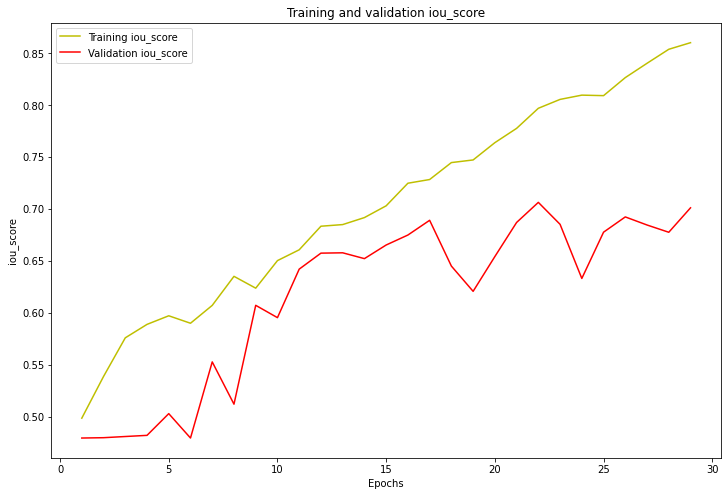

In [ ]:
#plot the training and validation accuracy and loss at each epoch
metrics = ["loss", "jacard_coef", "iou_score", "f1-score", "precision", "recall"]
metric = metrics[2] # IoU
#metric = metrics[3] # F1

loss = history[metric]
val_loss = history[f"val_{metric}"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'y', label=f'Training {metric}')
plt.plot(epochs, val_loss, 'r', label=f'Validation {metric}')

plt.title(f'Training and validation {metric}')
plt.xlabel('Epochs')
plt.ylabel(metric)
plt.legend()

#plt.savefig(f'Train_History_Img/history_{metric}-PSPNET.png') ### FLAG ### CHANGE CNN Name

plt.show()

## Predictions

In [ ]:
# Evaluation
# https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb
# https://segmentation-models.readthedocs.io/en/latest/api.html
# https://www.kaggle.com/code/animeshganai/notebooka5d51c716d

In [ ]:
# Garbage Collector - use it like gc.collect()
import tensorflow as tf

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
del y_train 
del X_train 

In [ ]:
#IOU
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


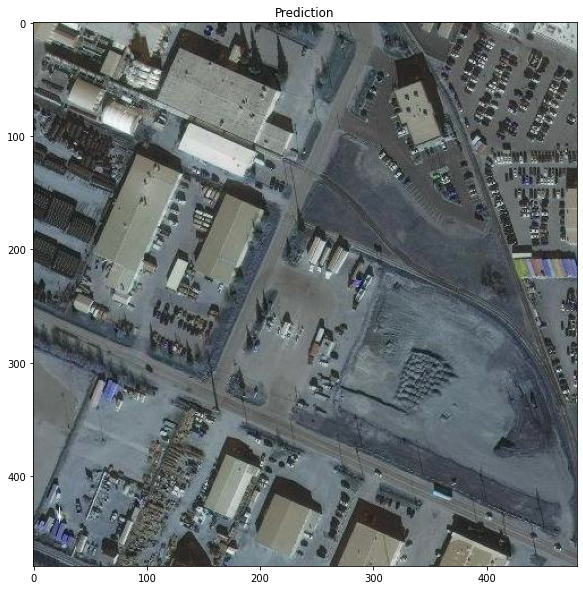

In [ ]:
# Predict on a random image
test_img_number = random.randint(0, len(X_test)-1)

test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(10, 10))

plt.title('Prediction')
plt.imshow(test_img)

cmap_c = ListedColormap([(0.1, 0.2, 0.5, 0), "red"])

plt.imshow(predicted_img, cmap=cmap_c, alpha=0.3) # cmap="Greens",

plt.show()

In [ ]:
# Get several predicted images
id_from = 0

id_to = 20 #len(X_test)

cmap_c = ListedColormap([(0.1, 0.2, 0.5, 0), "red"])

for i in range(id_from, id_to):
    test_img = X_test[i]
    test_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(10, 10))

    plt.title('Prediction')
    plt.imshow(test_img)

    plt.imshow(predicted_img, cmap=cmap_c, alpha=0.3)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.